In [2]:
%matplotlib inline
%load_ext rpy2.ipython
from genomics import data as gnd

In [156]:
import imp
imp.reload(gnd)

<module 'genomics.data' from '/Users/eczech/repos/portfolio/functional/ml/python/genomics/data.py'>

# Data Loading

In [11]:
datasets = gnd.get_raw_datasets()

Removing 6127 cols with more than 10 pct NA values
Removing 808 cols with more than 10 pct NA values


In [14]:
data = gnd.join_all_datasets(datasets, na_thresh=.9)

Frequency of row-wise NA pct values over threshold for removal:
1    5
dtype: int64
Frequency of row-wise NA pct values over threshold for removal:
1    5
dtype: int64
The following tumors will be removed due to high sparsity in their feature values: ['COLO699', 'HCC1359', 'HCC1833', 'HCC2108', 'NCIH2073', 'T3M10']


In [16]:
data['response'] = gnd.get_response_value(data)

In [19]:
data.head()

,tumorID,res_AUC,res_IC50,type,ge:A1BG,ge:A1CF,ge:A2M,ge:A2M.AS1,ge:A2ML1,ge:A4GALT,...,mu:ZNF668,mu:ZNF669,mu:ZNF717,mu:ZNF772,mu:ZNF780B,mu:ZNF790,mu:ZNF836,mu:ZNF841,mu:ZSCAN31,response
0,AMO1,7.1835,NaN,o,0.4770,-0.3916,-0.4094,-0.0089,-0.4782,-0.8503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.666203
1,BL70,5.1900,NaN,o,0.3490,-0.2798,-0.4107,-0.5269,-0.2551,0.3981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535292
2,C2BBE1,5.1650,NaN,o,-1.1575,2.1572,-0.4039,-0.2162,-0.0852,-0.2069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521109
3,CALU3,3.0088,NaN,o,-1.4094,-0.0233,-0.3574,0.1450,-0.2354,0.4110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.702101
4,CALU6,3.0762,NaN,o,-1.0876,-0.2483,-0.5084,-0.7926,-0.0924,0.8559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.663865


# Data Prep

For several different hold out set sizes:
1. Split data into training and hold out
2. Fit normalizing transforms on training data and apply to hold out
3. Match features in hold out to training
4. Store both training and hold out sets

In [133]:
def split_data(data, n_ho=30, n_features=8000, n_min_mu=3):
    # Split into training and holdout
    is_ho = gnd.get_hold_out_mask(data, n_ho=n_ho)
    d_ho, d_tr = data.loc[is_ho], data[~is_ho]
    
    # Scale and dummy encode
    d_tr, scalers = gnd.prep_data(d_tr, scalers=None)
    d_ho, _ = gnd.prep_data(d_ho, scalers=scalers)
    
    # Run feature selection
    d_tr, d_ho = gnd.normalize_data_split(d_tr, d_ho, min_mu_ct=n_min_mu)
    d_tr, d_ho = gnd.select_features(d_tr, d_ho, k=n_features)
    
    return d_tr, d_ho

In [660]:
#for n_ho in [30, 45, 60, 75, 90, 105]:
for n_ho in [195, 225, 250]:
    print('Creating data sets with hold out size {}'.format(n_ho))
    d_tr, d_ho = split_data(data, n_ho=n_ho, n_features=8000)
    gnd.export_dataset(d_tr, d_ho, n_ho)

Creating data sets with hold out size 195
Creating data sets with hold out size 225
Creating data sets with hold out size 250


In [146]:
#d_tr_prep.reset_index().plot(kind='scatter', y='response', x='cn:A2M')

# Modeling

In [691]:
n_ho = 30
d_tr, d_ho = gnd.load_dataset(n_ho)

In [701]:
from ml.model import models, common, importances
from ml.model import summaries as ml_precis
from ml.model import ensemble
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, RandomizedLasso, Ridge, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_ridge import KernelRidge

features = [c for c in d_tr if c != 'response']
X, y = d_tr[features], d_tr['response']

# gbr_grid = {
#     'n_estimators': [1, 100, 1000],
#     'learning_rate': [.001, .01, .1, 1],
#     'min_samples_leaf': [1, 2, 5],
#     'max_depth': [1, 5, 13]
# }
gbr_grid = {
    'n_estimators': [100],
    'learning_rate': [.01, .1, .2],
    'min_samples_leaf': [3, 17, 25],
    'max_depth': [5],
    'max_features': [.3, .5, .7]
}
rf_grid = {
    'n_estimators': [1, 10, 100, 250],
    'min_samples_leaf': [1, 3],
    'max_depth': [1]
}
etr_grid = {
    'n_estimators': [10],
    'min_samples_leaf': [5],
    'min_samples_split': [10],
    'max_features': ['auto', .1, .3, .5, .8],
    'max_leaf_nodes': [40, 60, 80],
    'max_depth': [None]
}
svr_grid = {
    'C': np.logspace(-1, 2, 6),
    'degree': [3],
    'gamma': np.logspace(-6, -3, 6),
    'kernel': ['rbf'],
    'max_iter': [15000]
}
ridge_grid = {
    'alpha': np.logspace(-2, 5, 50)
}
enet_grid = {
    'l1_ratio': [.1, .3, .5, .7, .9, 1]
}


n_jobs = -1
etr = ExtraTreesRegressor(n_estimators=100, max_depth=None, max_leaf_nodes=100, 
                          min_samples_leaf=5, min_samples_split=10, max_features=.85, n_jobs=-1)



#rf = RandomForestRegressor()
gbr = Pipeline([ 
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.8)), 
            ('est', GridSearchCV(GradientBoostingRegressor(), gbr_grid, n_jobs=-1))
        ])

ridge = Pipeline([ 
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.5)),
            ('est', GridSearchCV(Ridge(normalize=True), ridge_grid, n_jobs=-1))
        ])
lasso = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.5)), 
            ('est', LassoCV(normalize=True, n_jobs=-1))
        ])
enet = Pipeline([ 
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.5)), 
            ('est', GridSearchCV(ElasticNetCV(n_jobs=-1, cv=5, max_iter=10000, normalize=True), enet_grid))
        ])
# nys_grid = {
#     'kernel_params': [{'n_components': 232}],
#     'kernel': ['rbf'],
#     #'alpha': np.logspace(-2, 2, 1),
#     'gamma': np.logspace(-6, -3, 1)
# }
nys_grid = {
    'feat__n_components': [100, 232],
    'feat__gamma': [.00006, .00001, .0001],#np.logspace(-6, -3, 8),
    'est__alpha': np.logspace(-3, 1, 5)
}
nys =  GridSearchCV(Pipeline([ 
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=.9)),
        ('feat', Nystroem()),
        ('est', Ridge()) 
    ]), nys_grid, cv=5, n_jobs=1)

svr = GridSearchCV(SVR(), svr_grid, cv=5, n_jobs=1)

ens = ensemble.EnsembleRegressor([enet, ridge, etr, svr])
#clfs = {'ridge': ridge, 'lasso': lasso, 'ens': ensemble}
#clfs = {'enet': enet}
clfs = {'nys': nys}

res = models.run_regressors(
    X, y, clfs, KFold(len(y), 10), keep_X=False, 
    par_n_jobs=1, par_verbose=1,
    log_file='/tmp/genomics_cv.log')

INFO:ml.model.log:Running model nys (Pipeline) on fold 1


Beginning cross validation (see /tmp/genomics_cv.log for progress updates)


KeyboardInterrupt: 

In [694]:
#PCA(n_components=.75).fit_transform(X).shape

In [695]:
ml_precis.summarize_grid_parameters(res)

model_name  variable                     
nys         est__alpha          0.10000       6
                                0.00100       3
                                1.00000       1
            feat__gamma         0.00006       6
                                0.00001       4
            feat__n_components  100.00000    10
dtype: int64

In [696]:
from sklearn.metrics import mean_squared_error
score_func = lambda clf, y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
#score_func = lambda clf, y_true, y_pred: mean_squared_error(y_true, y_pred)
scores = models.summarize_scores(res, score_func)
scores.groupby('model_name').mean()

,fold_id,score
model_name,,
nys,5.5,0.837145


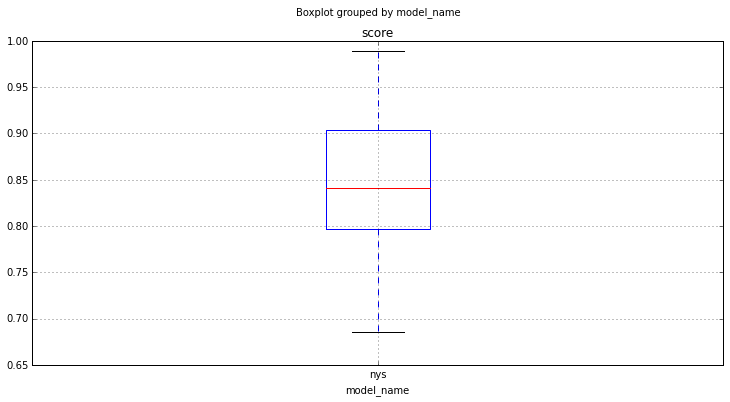

In [697]:
ml_precis.plot_model_scores(res, score_func)

In [ ]:
ml_precis.plot_feature_importance(res)

In [ ]:
preds = models.summarize_predictions(res)

# Predictions

In [702]:
nys_grid = {
    'feat__n_components': [100],
    #'feat__n_components': [100],
    'feat__gamma': [.00006],#np.logspace(-6, -3, 8),
    'est__alpha': np.logspace(-3, 1, 5)
}
nys =  GridSearchCV(Pipeline([ 
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=.9)),
        ('feat', Nystroem()),
        ('est', Ridge()) 
    ]), nys_grid, cv=5, n_jobs=1)
ens = ensemble.EnsembleRegressor([enet, ridge, nys])
n_ho = 250
d_tr_p, d_ho_p = gnd.load_dataset(n_ho)
features = [c for c in d_tr_p if c != 'response']
X, y = d_tr_p[features], d_tr_p['response']
ens.fit(X, y)

EnsembleRegressor(clfs=[Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=0.5, whiten=False)), ('est', GridSearchCV(backend='multiprocessing', cv=None, error_score='raise',
       estimator=ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, f...100]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)],
         voting='hard', weights=None)

(-2, 1)

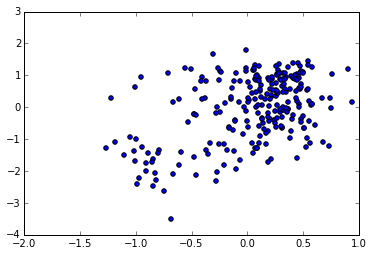

In [703]:
X_ho = d_ho_p[features]
y_ho = ens.predict(X_ho)
plt.scatter(y_ho, d_ho_p['response'])
plt.gca().set_xlim(-2, 1)

(-2, 1)

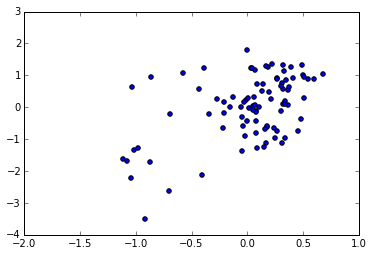

In [665]:
X_ho = d_ho_p[features]
y_ho = ens.predict(X_ho)
plt.scatter(y_ho, d_ho_p['response'])
plt.gca().set_xlim(-2, 1)

In [705]:
# Clustering
n_ho = 30
d_tr, d_ho = gnd.load_dataset(n_ho)

In [706]:
cors = d_tr.corr()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(d_tr.T)

In [ ]:
plt.scatter(tsne[:, 0], tsne[:, 1])